In [1]:
import tensorflow_core as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import scipy as sp
import sklearn.preprocessing as skp
import sklearn.model_selection as skm

In [112]:
social_network_ads = pd.read_csv("./Social_Network_Ads.csv")

x_dataset = social_network_ads.drop(\
    ["Purchased", "Gender", "User ID"], axis=1).to_numpy()
y_dataset =  social_network_ads["Purchased"].to_numpy()

x_train, x_test, y_train, y_test = \
    skm.train_test_split(\
         x_dataset, \
         y_dataset, \
         random_state = 0, test_size = 0.15)

scaler = skp.StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

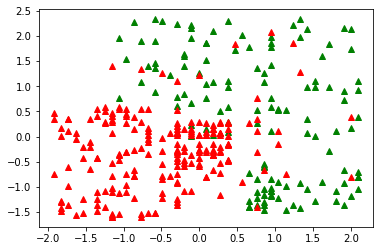

In [150]:
cluster_0 = [] # purchased
cluster_1 = [] # not purchased

for i in range(x_train.shape[0]):
    f = x_train[i]
    if y_train[i] == 1: cluster_0.append(f)
    else: cluster_1.append(f)

cluster_0 = np.array(cluster_0)
cluster_1 = np.array(cluster_1)

plt.plot(cluster_0[:, 0], cluster_0[:, 1], 'g^')
plt.plot(cluster_1[:, 0], cluster_1[:, 1], 'r^')
plt.show()

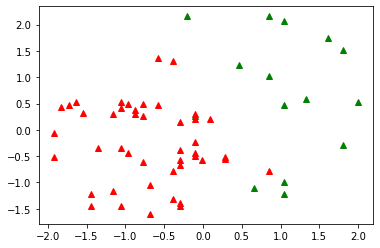

In [114]:
cluster_0 = [] # purchased
cluster_1 = [] # not purchased
for i in range(x_test.shape[0]):
    f = x_test[i]
    if y_test[i] == 1: cluster_0.append(f)
    else: cluster_1.append(f)

cluster_0 = np.array(cluster_0)
cluster_1 = np.array(cluster_1)

plt.plot(cluster_0[:, 0], cluster_0[:, 1], 'g^')
plt.plot(cluster_1[:, 0], cluster_1[:, 1], 'r^')
plt.show()

In [115]:
X1 = tf.placeholder(tf.float32, shape=(None,), name="x1")
X2 = tf.placeholder(tf.float32, shape=(None,), name="x2")
Y = tf.placeholder(tf.float32, shape=(None,), name="y")
reg_lambda = tf.placeholder(tf.float32, name="reg")

w = tf.Variable([0., 0., 0.], name="w", trainable=True)

def model(X2, X1, w):  # sigmoid model
    return tf.div(
        1.,
        tf.add(1., tf.exp(-1 * (w[2] * X2 + w[1] * X1 + w[0])),
    ))

y_model = model(X2, X1, w)

In [116]:
learning_rate = 0.001
training_epochs = 1000

cost = tf.add(
   tf.reduce_mean(\
       tf.subtract(\
           -1 * Y * tf.log(y_model), \
           (1 - Y) * tf.log(1 - y_model)
       )
   ),
   tf.multiply(reg_lambda, tf.reduce_sum(tf.square(w))),
)
train_op = tf.train.GradientDescentOptimizer\
   (learning_rate).minimize(cost)

In [117]:
min_cost = x_train.shape[1]
final_w = np.array([0.0, 0.0, 0.0])

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

for lambda_val in np.linspace(0, 1, 100):
    for epoch in range(training_epochs):
        sess.run(train_op, \
             feed_dict={X1: x_train[:, 0],\
                        X2: x_train[:, 1],\
                        Y: y_train,\
                       reg_lambda: lambda_val})

    testing_cost = sess.run(cost,\
             feed_dict={X1: x_test[:, 0],\
                        X2: x_test[:, 1],\
                        Y: y_test,\
                        reg_lambda: lambda_val})
    
    if testing_cost <= min_cost:
        min_cost = testing_cost
        final_w = sess.run(w)
        
        print(min_cost)
        print(final_w)

    w.assign([0.] * 3) # reset parameters

# sess.close()

0.5558815
[-0.10945873  0.25383615  0.14760572]
0.4763408
[-0.19323534  0.44472915  0.25460604]
0.4330765
[-0.25567186  0.58509606  0.33075714]
0.4127099
[-0.30027536  0.6843375   0.38298425]
0.40673333
[-0.32987854  0.7495755   0.41617158]


In [128]:
from sklearn.metrics import confusion_matrix

def floor_t(arr):
    for i, v in enumerate(arr):
        if v <= 0.5: arr[i] = 0
        else: arr[i] = 1        
    return arr

def make_prediction(x2, x1, w):
    return floor_t(1 / \
       (1. + \
        np.exp(-1 * (x2 * w[2] + x1 * w[1] + w[0]))))

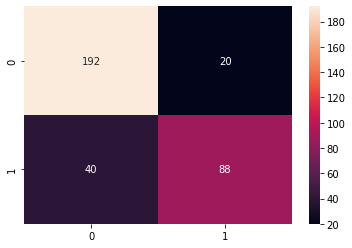

In [143]:
cm = confusion_matrix(y_train, \
    make_prediction(x_train[:, 1], x_train[:, 0], final_w))
sb.heatmap(cm, annot=True, fmt='g')
plt.show()

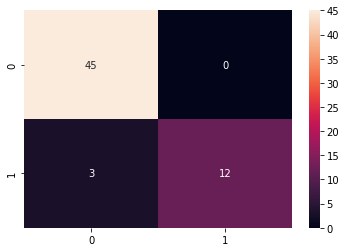

In [142]:
cm = confusion_matrix(y_test, \
    make_prediction(x_test[:, 1], x_test[:, 0], final_w))
sb.heatmap(cm, annot=True, fmt='g')
plt.show()